# Fisheries competition

In this notebook we're going to investigate a range of different architectures for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/).  The video states that vgg.py and ``vgg_ft()`` from utils.py have been updated to include VGG with batch normalization, but this is not the case.  We've instead created a new file [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py) and an additional method ``vgg_ft_bn()`` (which is already in utils.py) which we use in this notebook.

In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [3]:
%matplotlib inline
import utils#; reload(utils)
from utils import *
from __future__ import division, print_function

In [4]:
#path = "data/fish/sample/"
path = "data/nof_excl/"
batch_size=64

In [16]:
# batches = get_batches(path+'train', batch_size=batch_size)
# val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 2912 images belonging to 7 classes.
Found 400 images belonging to 7 classes.
Found 1000 images belonging to 1 classes.


Sometimes it's helpful to have just the filenames, without the path.

In [17]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

In [18]:
raw_test_filenames[0]

'img_06237.jpg'

## Setup dirs

We create the validation and sample sets in the usual way.

In [4]:
%pwd

u'/home/ubuntu/fish'

In [5]:
%cd data
%cd train
%mkdir "../valid"

/home/ubuntu/fish/data
/home/ubuntu/fish/data/train


In [6]:
%ls "../"

__MACOSX/                       test_stg1/     train.zip
sample_submission_stg1.csv      test_stg1.zip  valid/
sample_submission_stg1.csv.zip  train/


In [18]:
%pwd

'C:\\Users\\Armin\\Projects\\fish\\data\\train'

In [7]:
g = glob('*')
for d in g: os.mkdir('../valid/'+d)

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [8]:
%mkdir "../sample"
%mkdir "../sample/train"
%mkdir "../sample/valid"

In [9]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [10]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/home/ubuntu/fish/data/valid
/home/ubuntu/fish/data


In [20]:
%cd data


/home/ubuntu/fish/data


In [21]:
%mkdir results
%mkdir sample/results
%cd ..

/home/ubuntu/fish


In [12]:
# %mkdir "results"
# %mkdir "sample/results"
%pwd
%cd "~/fish"

/home/ubuntu/fish


## Basic VGG

We start with our usual VGG approach.  We will be using VGG with batch normalization.  We explained how to add batch normalization to VGG in the [imagenet_batchnorm notebook](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/imagenet_batchnorm.ipynb).  VGG with batch normalization is implemented in [vgg_bn.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/vgg16bn.py), and there is a version of ``vgg_ft`` (our fine tuning function) with batch norm called ``vgg_ft_bn`` in [utils.py](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py).

### Initial model

First we create a simple fine-tuned VGG model to be our starting point.

In [34]:
??ft

Object `ft` not found.


In [13]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

16384/35363 [============>.................] - ETA: 0s

In [37]:
path = "data/"

In [15]:
trn = get_data(path+'train')
val = get_data(path+'valid')

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.


In [32]:
test = get_data(path+'test')

Found 1000 images belonging to 1 classes.


In [22]:
save_array(path+'results/trn.dat', trn)
save_array(path+'results/val.dat', val)

In [33]:
save_array(path+'results/test.dat', test)

In [23]:
trn = load_array(path+'results/trn.dat')
val = load_array(path+'results/val.dat')

In [54]:
test = load_array(path+'results/test.dat')

>change to augmentation

In [25]:
gen = image.ImageDataGenerator()

In [26]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 96s - loss: 2.9373 - acc: 0.4632 - val_loss: 1.5033 - val_acc: 0.6560
Epoch 2/3
3277/3277 [==============================] - 95s - loss: 1.6093 - acc: 0.6524 - val_loss: 0.8924 - val_acc: 0.7640
Epoch 3/3
3277/3277 [==============================] - 95s - loss: 1.2897 - acc: 0.7058 - val_loss: 0.6680 - val_acc: 0.8260


In [28]:
model.save_weights(path+'results/ft1.h5')

### Precompute convolutional output

We pre-compute the output of the last convolution layer of VGG, since we're unlikely to need to fine-tune those layers. (All following analysis will be done on just the pre-computed convolutional features.)

In [50]:
model.load_weights(path+'results/ft1.h5')

In [34]:
??split_at

In [35]:
conv_layers,fc_layers = split_at(model, Convolution2D)

In [36]:
conv_model = Sequential(conv_layers)

In [38]:
conv_feat = conv_model.predict(trn)
conv_val_feat = conv_model.predict(val)

In [42]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[1][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[1][0]            
___________________________________________________________________________________________

In [40]:
conv_feat.shape

(3277, 512, 14, 14)

In [43]:
conv_test_feat = conv_model.predict(test)

In [44]:
save_array(path+'results/conv_val_feat.dat', conv_val_feat)
save_array(path+'results/conv_feat.dat', conv_feat)

In [45]:
save_array(path+'results/conv_test_feat.dat', conv_test_feat)

In [53]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')

In [829]:
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [46]:
conv_val_feat.shape

(500, 512, 14, 14)

### Train model

We can now create our first baseline model - a simple 3-layer FC net.

In [161]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [160]:
p=0.4

In [51]:
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 1.0955 - acc: 0.6823 - val_loss: 0.8798 - val_acc: 0.8040
Epoch 2/3
3277/3277 [==============================] - 2s - loss: 0.3125 - acc: 0.9136 - val_loss: 0.2653 - val_acc: 0.9260
Epoch 3/3
3277/3277 [==============================] - 2s - loss: 0.1410 - acc: 0.9655 - val_loss: 0.1776 - val_acc: 0.9560


In [53]:
bn_model.optimizer.lr = 1e-4

In [58]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 0.0327 - acc: 0.9918 - val_loss: 0.1243 - val_acc: 0.9660
Epoch 2/3
3277/3277 [==============================] - 2s - loss: 0.0299 - acc: 0.9902 - val_loss: 0.1117 - val_acc: 0.9680
Epoch 3/3
3277/3277 [==============================] - 2s - loss: 0.0286 - acc: 0.9918 - val_loss: 0.1254 - val_acc: 0.9720


In [60]:
bn_model.save_weights(path+'models/conv_512_6.h5')

In [59]:
bn_model.evaluate(conv_val_feat, val_labels)

500/500 [==============================] - 0s     


[0.12536175536317751, 0.97199999952316285]

In [774]:
bn_model.load_weights(path+'models/conv_512_6.h5')

## Multi-input

The images are of different sizes, which are likely to represent the boat they came from (since different boats will use different cameras). Perhaps this creates some data leakage that we can take advantage of to get a better Kaggle leaderboard position? To find out, first we create arrays of the file sizes for each image:

In [21]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [33]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 169,
         (1244, 700): 23,
         (1276, 718): 192,
         (1280, 720): 1880,
         (1280, 750): 520,
         (1280, 924): 51,
         (1280, 974): 344,
         (1334, 750): 28,
         (1518, 854): 37,
         (1732, 974): 33})

Then we one-hot encode them (since we want to treat them as categorical) and normalize the data.

In [34]:
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [88]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [36]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

To use this additional "meta-data", we create a model with multiple input layers - `sz_inp` will be our input for the size information.

In [37]:
p=0.6

In [38]:
inp = Input(conv_layers[-1].output_shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x,bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

When we compile the model, we have to specify all the input layers in an array.

In [39]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

And when we train the model, we have to provide all the input layers' data in an array.

In [40]:
model.fit([conv_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=([conv_val_feat, val_sizes], val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/3
3277/3277 [==============================] - 2s - loss: 1.1621 - acc: 0.6613 - val_loss: 0.6370 - val_acc: 0.8860
Epoch 2/3
3277/3277 [==============================] - 2s - loss: 0.3222 - acc: 0.8993 - val_loss: 0.2118 - val_acc: 0.9600
Epoch 3/3
3277/3277 [==============================] - 2s - loss: 0.1668 - acc: 0.9542 - val_loss: 0.1140 - val_acc: 0.9740


In [41]:
bn_model.optimizer.lr = 1e-4

In [42]:
bn_model.fit(conv_feat, trn_labels, batch_size=batch_size, nb_epoch=8, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/8
3277/3277 [==============================] - 1s - loss: 0.0666 - acc: 0.9774 - val_loss: 0.0928 - val_acc: 0.9900
Epoch 2/8
3277/3277 [==============================] - 1s - loss: 0.0363 - acc: 0.9905 - val_loss: 0.0997 - val_acc: 0.9840
Epoch 3/8
3277/3277 [==============================] - 1s - loss: 0.0292 - acc: 0.9924 - val_loss: 0.0840 - val_acc: 0.9900
Epoch 4/8
3277/3277 [==============================] - 1s - loss: 0.0375 - acc: 0.9905 - val_loss: 0.0862 - val_acc: 0.9900
Epoch 5/8
3277/3277 [==============================] - 1s - loss: 0.0218 - acc: 0.9939 - val_loss: 0.1155 - val_acc: 0.9880
Epoch 6/8
3277/3277 [==============================] - 1s - loss: 0.0292 - acc: 0.9905 - val_loss: 0.1033 - val_acc: 0.9900
Epoch 7/8
3277/3277 [==============================] - 1s - loss: 0.0173 - acc: 0.9921 - val_loss: 0.1030 - val_acc: 0.9900
Epoch 8/8
3277/3277 [==============================] - 1s - loss: 0.0186 - acc: 0.993

The model did not show an improvement by using the leakage, other than in the early epochs. This is most likely because the information about what boat the picture came from is readily identified from the image itself, so the meta-data turned out not to add any additional information.

## Bounding boxes & multi output

### Import / view bounding boxes

A kaggle user has created bounding box annotations for each fish in each training set image. You can download them [from here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/25902/complete-bounding-box-annotation). We will see if we can utilize this additional information. First, we'll load in the data, and keep just the largest bounding box for each image.

In [58]:
import ujson as json

In [60]:
path

'data/nof_excl/'

In [62]:
bb_json = {}
for c in anno_classes:
    j = json.load(open('{}bb_annos/{}_labels.json'.format(path, c), 'r'))
    mj = json.load(open('{}mouth_annos/{}_labels.json'.format(path,c), 'r'))
    print ("corresponding json file lengths: ",len(j),len(mj))

    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            
            filename = l['filename'].split('/')[-1]

#             bb_json[l['filename'].split('/')[-1]] = sorted(
#                 l['annotations'], key=lambda x: x['height']*x['width'])[-1]
            
            
            #find mounth and tail coordinates from the other json file
            bb_json[filename] = {}
            try:
                found_index = next(index for (index, d) in enumerate(mj) if d["filename"] == filename)
                bb_json[filename]["mouthntail"] =  mj[found_index]['annotations']
                
            except StopIteration:
                print (l['filename'], "not found in mount n tail")
                


corresponding json file lengths:  1719 1720
corresponding json file lengths:  200 201
corresponding json file lengths:  117 118
corresponding json file lengths:  67 68
corresponding json file lengths:  299 300
corresponding json file lengths:  176 177
corresponding json file lengths:  734 735


In [63]:
bb_json['img_04908.jpg']

{'mouthntail': [{u'class': u'point',
   u'x': 462.10189665916823,
   u'y': 522.3760570929728},
  {u'class': u'point', u'x': 823.7468592619955, u'y': 688.1299982859354}]}

In [68]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

For any images that have no annotations, we'll create an empty bounding box.

In [69]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.,"mouthntail":[] }

In [70]:
for f in raw_filenames:
    if not f in bb_json.keys():
        print (f, " not found")
        bb_json[f] = empty_bbox
        
for f in raw_val_filenames:
    if not f in bb_json.keys(): 
        print (f, " not found")
        bb_json[f] = empty_bbox

img_00576.jpg  not found
img_07008.jpg  not found
img_04798.jpg  not found
img_01958.jpg  not found
img_06460.jpg  not found
img_00425.jpg  not found
img_00568.jpg  not found
img_00379.jpg  not found
img_05444.jpg  not found
img_06773.jpg  not found
img_06082.jpg  not found
img_02785.jpg  not found
img_04558.jpg  not found
img_03183.jpg  not found
img_02292.jpg  not found


Finally, we convert the dictionary into an array, and convert the coordinates to our resized 224x224 images.

In [19]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    
    
#     bb = [bb[p] for p in bb_params]
#     conv_x = (224. / size[0])
#     conv_y = (224. / size[1])
#     bb[0] = bb[0]*conv_y
#     bb[1] = bb[1]*conv_x
#     bb[2] = max(bb[2]*conv_x, 0)
#     bb[3] = max(bb[3]*conv_y, 0)
#     return bb

    mt = bb["mouthntail"]
    
    bb = [bb[p] for p in bb_params]
    
    #adding mouth n tail ccordinates
    try:
        
        if len(mt) >0:
            bb.extend([mt[0]['x'],mt[0]['y'],mt[1]['x'],mt[1]['y']])
        else:
            bb.extend([0,0,0,0])
    except IndexError:
        print ("empty mouth n tail")   

            
    
    
    # conversion factors
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])

    # make the size conversions
#     width, height = size[0]*conv_x, size[1]*conv_y
    x = bb[2]*conv_x
    y = bb[3]*conv_y

    #mouth
    mx = bb[4]*conv_x
    my = bb[5]*conv_y

    #tail
    tx = bb[6]*conv_x
    ty = bb[7]*conv_y

     
    # offset/padding adjustments
    x = max(x - 10, 0)
    y = max(y - 10, 0)

    # make sure we're not overshooting the photo
#     if x + cropsize > width:
#         x = width - cropsize
#     if y + cropsize > height:
#         y = height - cropsize
    
    bb[0] = bb[0]*conv_y+10
    bb[1] = bb[1]*conv_x+10
    bb[2] = x
    bb[3] = y
    bb[4] = mx
    bb[5] = my
    bb[6] = tx
    bb[7] = ty  
    
    
    return bb


In [78]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb_mouth_only(bb, size):
    
    
#     bb = [bb[p] for p in bb_params]
#     conv_x = (224. / size[0])
#     conv_y = (224. / size[1])
#     bb[0] = bb[0]*conv_y
#     bb[1] = bb[1]*conv_x
#     bb[2] = max(bb[2]*conv_x, 0)
#     bb[3] = max(bb[3]*conv_y, 0)
#     return bb

    mt = bb["mouthntail"]
    bb = []    
    #adding mouth n tail ccordinates
    try:
        
        if len(mt) >0:
            bb.extend([mt[0]['x'],mt[0]['y'],mt[1]['x'],mt[1]['y']])
        else:
            bb.extend([0,0,0,0])
    except IndexError:
        print ("empty mouth n tail")   

            
    
    
    # conversion factors
    conv_x = (640. / size[0])
    conv_y = (360. / size[1])


    #mouth
    mx = bb[0]*conv_x
    my = bb[1]*conv_y

    #tail
    tx = bb[2]*conv_x
    ty = bb[3]*conv_y



    bb[0] = mx
    bb[1] = my
    bb[2] = tx
    bb[3] = ty  
    
    
    return bb


In [79]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]




# trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
#                    ).astype(np.float32)
# val_bbox = np.stack([convert_bb(bb_json[f], s) 
#                    for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [80]:
trn_bbox = np.stack([convert_bb_mouth_only(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb_mouth_only(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)


Now we can check our work by drawing one of the annotations.

In [84]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def create_point(pt, color='red'):
    return plt.Circle(pt,8, color=color,fill=True)


def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
#     plt.gca().add_patch(create_rect(bb))
#     plt.gca().add_patch(create_point((bb[4], bb[5])))
#     plt.gca().add_patch(create_point((bb[6], bb[7]),"blue")) 
    plt.gca().add_patch(create_point((bb[0], bb[1])))
    plt.gca().add_patch(create_point((bb[2], bb[3]),"blue")) 

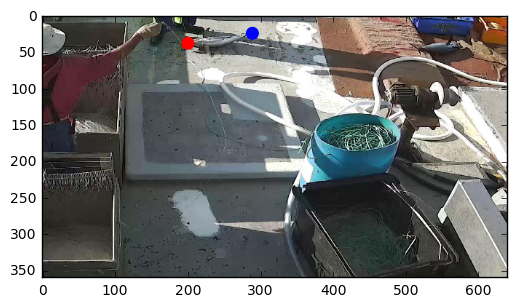

In [85]:
show_bb(399)

### Create & train model

Since we're not allowed (by the kaggle rules) to manually annotate the test set, we'll need to create a model that predicts the locations of the bounding box on each image. To do so, we create a model with multiple outputs: it will predict both the type of fish (the 'class'), and the 4 bounding box coordinates. We prefer this approach to only predicting the bounding box coordinates, since we hope that giving the model more context about what it's looking for will help it with both tasks.

In [86]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [87]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')
conv_test_feat = load_array(path+'results/conv_test_640.dat')


In [88]:
conv_layers,_ = split_at(vgg640, Convolution2D)


In [89]:
p=0.6

In [90]:
inp = Input(conv_layers[-1].output_shape[1:])
x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x_bb = Dense(4, name='bb')(x)
x_class = Dense(7, activation='softmax', name='class')(x)

Since we have multiple outputs, we need to provide them to the model constructor in an array, and we also need to say what loss function to use for each. We also weight the bounding box loss function down by 1000x since the scale of the cross-entropy loss and the MSE is very different.

In [91]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [92]:
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/5
2912/2912 [==============================] - 8s - loss: 71.1853 - bb_loss: 70183.4143 - class_loss: 1.0019 - bb_acc: 0.3750 - class_acc: 0.7194 - val_loss: 61.2789 - val_bb_loss: 60396.9725 - val_class_loss: 0.8819 - val_bb_acc: 0.3900 - val_class_acc: 0.8625
Epoch 2/5
2912/2912 [==============================] - 8s - loss: 67.3212 - bb_loss: 67126.5128 - class_loss: 0.1947 - bb_acc: 0.3829 - class_acc: 0.9440 - val_loss: 58.6697 - val_bb_loss: 58579.1956 - val_class_loss: 0.0905 - val_bb_acc: 0.4650 - val_class_acc: 0.9775
Epoch 3/5
2912/2912 [==============================] - 8s - loss: 62.2282 - bb_loss: 62119.1055 - class_loss: 0.1091 - bb_acc: 0.4351 - class_acc: 0.9736 - val_loss: 55.3643 - val_bb_loss: 55294.9491 - val_class_loss: 0.0694 - val_bb_acc: 0.5125 - val_class_acc: 0.9800
Epoch 4/5
2912/2912 [==============================] - 8s - loss: 54.9995 - bb_loss: 54915.5886 - class_loss: 0.0839 - bb_acc: 0.4457 - class_a

In [93]:
model.optimizer.lr = 1e-4

In [94]:
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/10
2912/2912 [==============================] - 8s - loss: 34.3007 - bb_loss: 34223.7956 - class_loss: 0.0769 - bb_acc: 0.4705 - class_acc: 0.9780 - val_loss: 26.3045 - val_bb_loss: 26202.0264 - val_class_loss: 0.1025 - val_bb_acc: 0.5050 - val_class_acc: 0.9725
Epoch 2/10
2912/2912 [==============================] - 8s - loss: 22.8401 - bb_loss: 22770.0884 - class_loss: 0.0701 - bb_acc: 0.4969 - class_acc: 0.9804 - val_loss: 15.8638 - val_bb_loss: 15778.3920 - val_class_loss: 0.0854 - val_bb_acc: 0.5475 - val_class_acc: 0.9775
Epoch 3/10
2912/2912 [==============================] - 8s - loss: 13.7073 - bb_loss: 13634.9521 - class_loss: 0.0723 - bb_acc: 0.5192 - class_acc: 0.9749 - val_loss: 8.6118 - val_bb_loss: 8509.9176 - val_class_loss: 0.1019 - val_bb_acc: 0.5625 - val_class_acc: 0.9775
Epoch 4/10
2912/2912 [==============================] - 8s - loss: 7.6541 - bb_loss: 7602.0562 - class_loss: 0.0520 - bb_acc: 0.5543 - class_a

In [95]:
model.optimizer.lr = 1e-5
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=15, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/15
2912/2912 [==============================] - 8s - loss: 1.2286 - bb_loss: 1209.5405 - class_loss: 0.0190 - bb_acc: 0.8468 - class_acc: 0.9948 - val_loss: 1.9728 - val_bb_loss: 1842.3947 - val_class_loss: 0.1304 - val_bb_acc: 0.8600 - val_class_acc: 0.9800
Epoch 2/15
2912/2912 [==============================] - 8s - loss: 1.1563 - bb_loss: 1132.5649 - class_loss: 0.0238 - bb_acc: 0.8472 - class_acc: 0.9907 - val_loss: 1.9498 - val_bb_loss: 1798.2830 - val_class_loss: 0.1515 - val_bb_acc: 0.8625 - val_class_acc: 0.9800
Epoch 3/15
2912/2912 [==============================] - 8s - loss: 1.1055 - bb_loss: 1083.7570 - class_loss: 0.0217 - bb_acc: 0.8565 - class_acc: 0.9952 - val_loss: 2.0080 - val_bb_loss: 1879.4750 - val_class_loss: 0.1285 - val_bb_acc: 0.8500 - val_class_acc: 0.9775
Epoch 4/15
2912/2912 [==============================] - 8s - loss: 0.9791 - bb_loss: 965.4485 - class_loss: 0.0136 - bb_acc: 0.8644 - class_acc: 0.9959 

In [96]:
model.optimizer.lr = 1e-6
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=15, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/15
2912/2912 [==============================] - 8s - loss: 0.7903 - bb_loss: 775.7990 - class_loss: 0.0145 - bb_acc: 0.8829 - class_acc: 0.9942 - val_loss: 1.9732 - val_bb_loss: 1813.5112 - val_class_loss: 0.1597 - val_bb_acc: 0.8825 - val_class_acc: 0.9825
Epoch 2/15
2912/2912 [==============================] - 8s - loss: 0.7829 - bb_loss: 768.0670 - class_loss: 0.0149 - bb_acc: 0.8791 - class_acc: 0.9945 - val_loss: 2.0027 - val_bb_loss: 1817.7015 - val_class_loss: 0.1850 - val_bb_acc: 0.8725 - val_class_acc: 0.9725
Epoch 3/15
2912/2912 [==============================] - 8s - loss: 0.7574 - bb_loss: 750.4302 - class_loss: 0.0069 - bb_acc: 0.8839 - class_acc: 0.9979 - val_loss: 1.9687 - val_bb_loss: 1788.0151 - val_class_loss: 0.1807 - val_bb_acc: 0.8775 - val_class_acc: 0.9775
Epoch 4/15
2912/2912 [==============================] - 8s - loss: 0.7538 - bb_loss: 739.4397 - class_loss: 0.0144 - bb_acc: 0.8922 - class_acc: 0.9948 - v

bbaccuracy on both training and avalidation is still increasing so we continue

In [99]:
model.optimizer.lr = 1e-7
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/2
2912/2912 [==============================] - 8s - loss: 0.6195 - bb_loss: 610.9245 - class_loss: 0.0086 - bb_acc: 0.8894 - class_acc: 0.9969 - val_loss: 1.9242 - val_bb_loss: 1759.4751 - val_class_loss: 0.1647 - val_bb_acc: 0.8825 - val_class_acc: 0.9800
Epoch 2/2
2912/2912 [==============================] - 8s - loss: 0.5820 - bb_loss: 570.2182 - class_loss: 0.0118 - bb_acc: 0.8942 - class_acc: 0.9952 - val_loss: 1.9514 - val_bb_loss: 1781.7031 - val_class_loss: 0.1697 - val_bb_acc: 0.8825 - val_class_acc: 0.9800


In [100]:
model.save_weights(path+"models/mouth_only_regressor_640_val_bb_acc_0.8825_val_class_acc_0.9952.h5")

Excitingly, it turned out that the classification model is much improved by giving it this additional task. Let's see how well the bounding box model did by taking a look at its output.

In [101]:
pred = model.predict(conv_val_feat)#[0:20]

In [102]:
len(pred[1][2])

7

In [112]:
def create_point(pt, color='red',fill=True):
    return plt.Circle(pt,8, color=color,fill=fill)



def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]#0:bounding box, 1: class
    plt.figure(figsize=(6,6))
    plot(val[i])
#     ax=plt.gca()
#     ax.add_patch(create_rect(bb_pred, 'yellow'))
#     ax.add_patch(create_rect(bb))
#     plt.gca().add_patch(create_point((bb_pred[4], bb_pred[5])))
#     plt.gca().add_patch(create_point((bb_pred[6], bb_pred[7]),"blue"))    
    plt.gca().add_patch(create_point((bb[0], bb[1]),fill=False))
    plt.gca().add_patch(create_point((bb[2], bb[3]),"blue",fill=False))  
    
    plt.gca().add_patch(create_point((bb_pred[0], bb_pred[1])))
    plt.gca().add_patch(create_point((bb_pred[2], bb_pred[3]),"blue"))    


The image shows that it can find fish that are tricky for us to see!

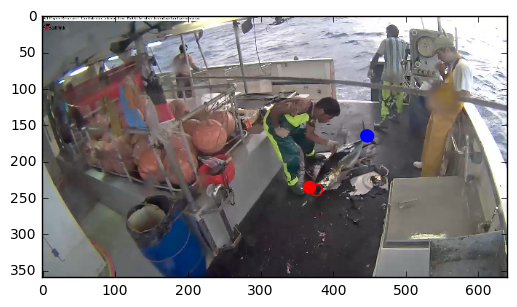

In [126]:
show_bb_pred(342)

In [111]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

400/400 [==============================] - 0s     


[1.4134369325637817,
 1278.2915942382813,
 0.13514526987302816,
 0.84499999999999997,
 0.97750000000000004]

In [112]:
# model.save_weights(path+'models/bn_anno.h5')
# model.load_weights(path+'models/bn_anno.h5')

In [127]:
pred = model.predict(conv_test_feat)#[0:20]


    

In [133]:
pred[0][1]

array([ 210.3743,  226.7695,  266.581 ,  206.9781], dtype=float32)

In [134]:

save_array(path+"results/mouth_only_test_predictions.data",pred[0])


In [3]:
# save_array(path+"results/bbox_mouth_test_predictions.data",pred)
# pred = load_array(path+"results/bbox_mouth_test_predictions.data")


In [147]:
def show_tst_pred(i):
#     bb = val_bbox[i]
    bb_pred = pred[0][i]#0:bounding box, 1: class
    print (len(bb_pred))
    plt.figure(figsize=(6,6))
    plot(test[i])
    ax=plt.gca()
#     ax.add_patch(create_rect(bb_pred, 'yellow'))
#     ax.add_patch(create_rect(bb))
#     plt.gca().add_patch(create_point((bb_pred[4], bb_pred[5])))
#     plt.gca().add_patch(create_point((bb_pred[6], bb_pred[7]),"blue"))    
    
    plt.gca().add_patch(create_point((bb_pred[0], bb_pred[1])))
    plt.gca().add_patch(create_point((bb_pred[2], bb_pred[3]),"blue"))    


4


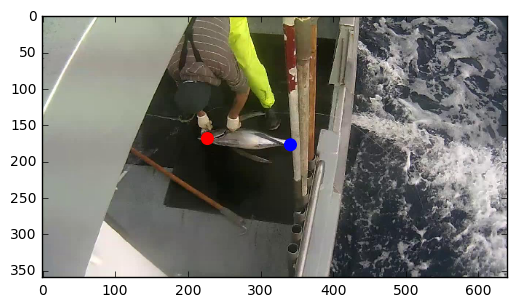

In [172]:
show_tst_pred (402)

results are miss and hit but let's assume theyre good for now and proceed with rotation/ crop

In [52]:
from skimage.transform import resize
from skimage.data import imread
from skimage.io import imshow,imsave
from skimage import img_as_float
from skimage.util import crop
from skimage.transform import rotate




def deg_angle_between(x1,y1,x2,y2):
    from math import atan2, degrees, pi
    dx = x2 - x1
    dy = y2 - y1
    rads = atan2(-dy,dx)
    rads %= 2*pi
    degs = degrees(rads)
    return(degs)


def get_rotated_cropped_fish(img,x1,y1,x2,y2,crop_ratio=1.1,resize_width=500):
    (h,w) = img.shape[0:2]
    print (img.shape[:2])
    print (x1,y1,x2,y2)
    #calculate center and angle
    center = ( (x1+x2) / 2,(y1+y2) / 2)
    angle = np.floor(-deg_angle_between(x1,y1,x2,y2))
    print('angle=' +str(angle) + ' ')
    print('center=' +str(center))
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    fish_length = np.sqrt((x1-x2)**2+(y1-y2)**2)
    
    crop_factor = fish_length/crop_ratio
    
    rots = np.floor([max((center[1]-crop_factor),0),\
                    max((center[1]+crop_factor),0),\
    max((center[0]- crop_factor),0),\
    max((center[0]+ crop_factor),0)]).astype(int)
    
    print (rots) 
    cropped = rotated[rots[0]:rots[1],rots[2]:rots[3]]
#     print ((max((center[1]-fish_length/1.8),0)))
#     print (max((center[1]+fish_length/1.8),0))
#     print (max((center[0]- fish_length/1.8),0))
#     print (max((center[0]+fish_length/1.8),0))
#     cropped = rotated[(max((center[1]-fish_length/1.8),0)):(max((center[1]+fish_length/1.8),0)) ,
#      (max((center[0]- fish_length/1.8),0)):(max((center[0]+fish_length/1.8),0))]

    imshow(img.transpose(2,0,1))
#     imshow(rotated)
#     imshow(cropped)
#     print (cropped.shape)
    
#     resized = resize(cropped,(resize_width,resize_width))
    return(cropped)


In [53]:
import cv2
def get_cropped_test(i):
    bb_pred = pred[i]#0:bounding box, 1: class
    rotated = get_rotated_cropped_fish(test[i].transpose(1,2,0),bb_pred[4], bb_pred[5],bb_pred[6], bb_pred[7])
    
#     imshow(rotated)

In [7]:
# imshow(test[2])

In [6]:
# get_cropped_test(290)

### Trying fully convnet with mouth regressor

In [175]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
vgg640.input_shape, vgg640.output_shape
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [176]:
conv_layers,_ = split_at(vgg640, Convolution2D)


In [177]:
nf=128; p=0.5


In [182]:
inp = Input(conv_layers[-1].output_shape[1:])
x = BatchNormalization(axis=1)(inp)
x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
x = BatchNormalization(axis=1)(x)
x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
x = BatchNormalization(axis=1)(x)
x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
x = BatchNormalization(axis=1)(x)


x_class = Convolution2D(7,3,3, border_mode='same')(x)
x_class = GlobalAveragePooling2D()(x_class)
x_class = Activation('softmax',name="class")(x_class)


x_bb = Flatten()(x)
x_bb = Dense(1024, activation='relu')(x_bb)
x_bb = BatchNormalization()(x_bb)
x_bb = Dropout(p)(x_bb)
x_bb = Dense(1024, activation='relu')(x_bb)
x_bb = BatchNormalization()(x_bb)
x_bb = Dropout(p/2)(x_bb)
x_bb = Dense(4, name='bb')(x_bb)



th


In [183]:
model = Model([inp], [x_bb, x_class])
model.compile(Adam(lr=0.001), loss=['mse', 'categorical_crossentropy'], metrics=['accuracy'],
             loss_weights=[.001, 1.])

In [184]:
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/5
2912/2912 [==============================] - 25s - loss: 69.0474 - bb_loss: 68099.6735 - class_loss: 0.9477 - bb_acc: 0.4190 - class_acc: 0.7215 - val_loss: 56.8552 - val_bb_loss: 53943.6805 - val_class_loss: 2.9115 - val_bb_acc: 0.3350 - val_class_acc: 0.4725
Epoch 2/5
2912/2912 [==============================] - 25s - loss: 63.8597 - bb_loss: 63597.5126 - class_loss: 0.2622 - bb_acc: 0.4512 - class_acc: 0.9262 - val_loss: 54.0367 - val_bb_loss: 52352.8709 - val_class_loss: 1.6839 - val_bb_acc: 0.5150 - val_class_acc: 0.6225
Epoch 3/5
2912/2912 [==============================] - 25s - loss: 58.4055 - bb_loss: 58271.1993 - class_loss: 0.1343 - bb_acc: 0.4722 - class_acc: 0.9663 - val_loss: 47.6928 - val_bb_loss: 47351.5020 - val_class_loss: 0.3413 - val_bb_acc: 0.5075 - val_class_acc: 0.9100
Epoch 4/5
2912/2912 [==============================] - 25s - loss: 51.0292 - bb_loss: 50940.2031 - class_loss: 0.0890 - bb_acc: 0.4856 - cla

In [186]:
model.optimizer.lr = 1e-4
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/10
2912/2912 [==============================] - 25s - loss: 29.2673 - bb_loss: 29225.9872 - class_loss: 0.0413 - bb_acc: 0.5182 - class_acc: 0.9907 - val_loss: 19.7076 - val_bb_loss: 19518.1012 - val_class_loss: 0.1895 - val_bb_acc: 0.5600 - val_class_acc: 0.9550
Epoch 2/10
2912/2912 [==============================] - 25s - loss: 18.7404 - bb_loss: 18702.5784 - class_loss: 0.0378 - bb_acc: 0.5450 - class_acc: 0.9911 - val_loss: 12.6493 - val_bb_loss: 12402.7872 - val_class_loss: 0.2465 - val_bb_acc: 0.5550 - val_class_acc: 0.9525
Epoch 3/10
2912/2912 [==============================] - 25s - loss: 10.7763 - bb_loss: 10749.1277 - class_loss: 0.0272 - bb_acc: 0.5680 - class_acc: 0.9928 - val_loss: 8.1184 - val_bb_loss: 7892.2067 - val_class_loss: 0.2262 - val_bb_acc: 0.5675 - val_class_acc: 0.9550
Epoch 4/10
2912/2912 [==============================] - 25s - loss: 5.8756 - bb_loss: 5856.5729 - class_loss: 0.0190 - bb_acc: 0.6198 - cla

In [187]:
model.optimizer.lr = 1e-5
model.fit(conv_trn_feat, [trn_bbox, trn_labels], batch_size=batch_size, nb_epoch=25, 
             validation_data=(conv_val_feat, [val_bbox, val_labels]))

Train on 2912 samples, validate on 400 samples
Epoch 1/25
2912/2912 [==============================] - 25s - loss: 0.6539 - bb_loss: 649.8113 - class_loss: 0.0041 - bb_acc: 0.8750 - class_acc: 1.0000 - val_loss: 1.9953 - val_bb_loss: 1804.5930 - val_class_loss: 0.1907 - val_bb_acc: 0.8650 - val_class_acc: 0.9600
Epoch 2/25
2912/2912 [==============================] - 25s - loss: 0.6334 - bb_loss: 629.7842 - class_loss: 0.0036 - bb_acc: 0.8764 - class_acc: 1.0000 - val_loss: 1.7738 - val_bb_loss: 1576.4927 - val_class_loss: 0.1974 - val_bb_acc: 0.8550 - val_class_acc: 0.9675
Epoch 3/25
2912/2912 [==============================] - 25s - loss: 0.5710 - bb_loss: 568.1682 - class_loss: 0.0028 - bb_acc: 0.8987 - class_acc: 1.0000 - val_loss: 1.8428 - val_bb_loss: 1610.1377 - val_class_loss: 0.2327 - val_bb_acc: 0.8700 - val_class_acc: 0.9625
Epoch 4/25
2912/2912 [==============================] - 25s - loss: 0.5904 - bb_loss: 588.4238 - class_loss: 0.0020 - bb_acc: 0.8922 - class_acc: 1.0000

In [ ]:
model.save_weights(path+"models/mouth_regressor_with_fullyconvnet_val_bb_acc_0.8925_val_class_acc_0.935.h5")

## Larger size

### Set up data

Let's see if we get better results if we use larger images. We'll use 640x360, since it's the same shape as the most common size we saw earlier (1280x720), without being too big.

In [14]:
path

'data/nof_excl/'

In [15]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

Found 2912 images belonging to 7 classes.
Found 400 images belonging to 7 classes.


The image shows that things are much clearer at this size.

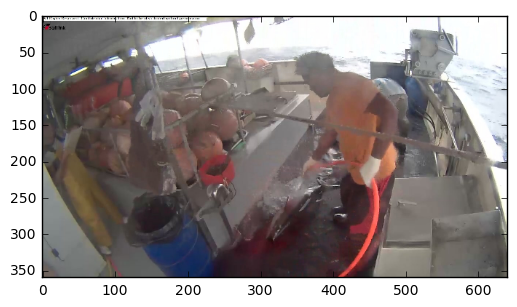

In [144]:
plot(trn[0])

In [8]:
test = get_data(path+'test', (360,640))

Found 1000 images belonging to 1 classes.


In [18]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)

In [19]:
save_array(path+'results/test_640.dat', test)

In [140]:
# trn = load_array(path+'results/trn_640.dat')
# val = load_array(path+'results/val_640.dat')
test = load_array(path+'results/test_640.dat')

We can now create our VGG model - we'll need to tell it we're not using the normal 224x224 images, which also means it won't include the fully connected layers (since they don't make sense for non-default sizes). We will also remove the last max pooling layer, since we don't want to throw away information yet.

In [20]:
vgg640 = Vgg16BN((360, 640)).model
vgg640.pop()
print (vgg640.input_shape, vgg640.output_shape)
vgg640.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

(None, 3, 360, 640) (None, 512, 22, 40)


We can now pre-compute the output of the convolutional part of VGG.

In [21]:
conv_val_feat = vgg640.predict(val, batch_size=32, verbose=1)
conv_trn_feat = vgg640.predict(trn, batch_size=32, verbose=1)

2912/2912 [==============================] - 340s   


In [22]:
save_array(path+'results/conv_val_640.dat', conv_val_feat)
save_array(path+'results/conv_trn_640.dat', conv_trn_feat)

In [23]:
conv_test_feat = vgg640.predict(test, batch_size=32, verbose=1)

1000/1000 [==============================] - 117s   


In [24]:
save_array(path+'results/conv_test_640.dat', conv_test_feat)

In [8]:
conv_val_feat = load_array(path+'results/conv_val_640.dat')
conv_trn_feat = load_array(path+'results/conv_trn_640.dat')
conv_test_feat = load_array(path+'results/conv_test_640.dat')

### Training and prediction 

In [ ]:
conv_layers,fc_layers = split_at(vgg640, Convolution2D)


In [ ]:
loadvgg640.summary()

In [163]:
bn_model = Sequential(get_bn_layers(p))


In [164]:
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [168]:
# bn_model.summary()
bn_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, val_labels))

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-2.7.12-64/lock_dir/lock


Train on 3277 samples, validate on 500 samples
Epoch 1/5
3277/3277 [==============================] - 24s - loss: 3.5853 - acc: 0.6573 - val_loss: 3.5055 - val_acc: 0.7480
Epoch 2/5
3277/3277 [==============================] - 24s - loss: 2.2464 - acc: 0.8294 - val_loss: 2.0818 - val_acc: 0.8300
Epoch 3/5
3277/3277 [==============================] - 24s - loss: 1.0067 - acc: 0.9048 - val_loss: 0.7275 - val_acc: 0.9300
Epoch 4/5
3277/3277 [==============================] - 24s - loss: 0.5078 - acc: 0.9558 - val_loss: 0.5626 - val_acc: 0.9460
Epoch 5/5
3277/3277 [==============================] - 24s - loss: 0.4425 - acc: 0.9533 - val_loss: 0.3440 - val_acc: 0.9580


In [176]:
# bn_model.save_weights(path+'models/640_vgg1_0.h5')
bn_model.load_weights(path+'models/640_vgg1_0.h5')


In [178]:
bn_model.optimizer.lr = 1e-5

bn_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=1, 
validation_data=(conv_val_feat, val_labels))



Train on 3277 samples, validate on 500 samples
Epoch 1/1
3277/3277 [==============================] - 24s - loss: 0.3377 - acc: 0.9725 - val_loss: 0.4279 - val_acc: 0.9580


### Fully convolutional net (FCN)

Since we're using a larger input, the output of the final convolutional layer is also larger. So we probably don't want to put a dense layer there - that would be a *lot* of parameters! Instead, let's use a fully convolutional net (FCN); this also has the benefit that they tend to generalize well, and also seems like a good fit for our problem (since the fish are a small part of the image).

In [25]:
conv_layers,_ = split_at(vgg640, Convolution2D)

I'm not using any dropout, since I found I got better results without it.

In [29]:
nf=128; p=0.

from keras.layers.pooling import GlobalMaxPooling2D
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        MaxPooling2D((1,2)),
        Convolution2D(7,3,3, border_mode='same'),
        Dropout(p),
        GlobalAveragePooling2D(), #change to Max
#         GlobalMaxPooling2D(),
        Activation('softmax')
    ]

In [30]:
lrg_model = Sequential(get_lrg_layers())

th


In [31]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_5 (BatchNormal(None, 512, 22, 40)   1024        batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_5[0][0]       
____________________________________________________________________________________________________
batchnormalization_6 (BatchNormal(None, 128, 22, 40)   256         convolution2d_31[0][0]           
____________________________________________________________________________________________________
maxpooling2d_14 (MaxPooling2D)   (None, 128, 11, 20)   0           batchnormalization_6[0][0]       
___________________________________________________________________________________________

In [32]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=5, 
             validation_data=(conv_val_feat, val_labels))

Train on 2912 samples, validate on 400 samples
Epoch 1/5
2912/2912 [==============================] - 12s - loss: 0.5720 - acc: 0.8128 - val_loss: 1.8526 - val_acc: 0.6375
Epoch 2/5
2912/2912 [==============================] - 12s - loss: 0.0605 - acc: 0.9849 - val_loss: 0.3981 - val_acc: 0.8775
Epoch 3/5
2912/2912 [==============================] - 12s - loss: 0.0222 - acc: 0.9962 - val_loss: 0.2368 - val_acc: 0.9475
Epoch 4/5
2912/2912 [==============================] - 12s - loss: 0.0130 - acc: 0.9973 - val_loss: 0.1690 - val_acc: 0.9375
Epoch 5/5
2912/2912 [==============================] - 12s - loss: 0.0231 - acc: 0.9962 - val_loss: 0.1414 - val_acc: 0.9625


In [34]:
lrg_model.optimizer.lr=1e-6

In [36]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(conv_val_feat, val_labels))

Train on 2912 samples, validate on 400 samples
Epoch 1/3
2912/2912 [==============================] - 12s - loss: 1.5674e-04 - acc: 1.0000 - val_loss: 0.1221 - val_acc: 0.9700
Epoch 2/3
2912/2912 [==============================] - 12s - loss: 1.3774e-04 - acc: 1.0000 - val_loss: 0.1230 - val_acc: 0.9700
Epoch 3/3
2912/2912 [==============================] - 12s - loss: 1.1586e-04 - acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.9725


When I submitted the results of this model to Kaggle, I got the best single model results of any shown here (ranked 22nd on the leaderboard as at Dec-6-2016.)

In [37]:
lrg_model.save_weights(path+'models/lrg_fcnn.h5')

In [870]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

In [38]:
lrg_model.evaluate(conv_val_feat, val_labels)

400/400 [==============================] - 0s     


[0.12135673876153305, 0.97250000000000003]

Another benefit of this kind of model is that the last convolutional layer has to learn to classify each part of the image (since there's only an average pooling layer after). Let's create a function that grabs the output of this layer (which is the 4th-last layer of our model).

In [872]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)

In [881]:
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640), interp='nearest')

We have to add an extra dimension to our input since the CNN expects a 'batch' (even if it's just a batch of one).

In [882]:
inp = np.expand_dims(conv_val_feat[0], 0)
np.round(lrg_model.predict(inp)[0],2)

array([ 0.82,  0.  ,  0.  ,  0.  ,  0.17,  0.  ,  0.  ,  0.  ], dtype=float32)

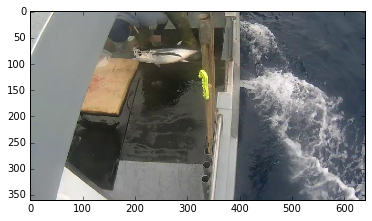

In [883]:
plt.imshow(to_plot(val[0]))

In [885]:
cm = get_cm(inp, 0)

The heatmap shows that (at very low resolution) the model is finding the fish!

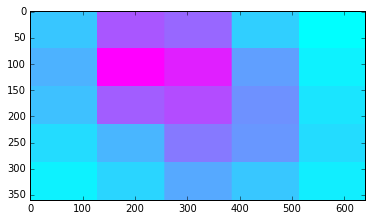

In [886]:
plt.imshow(cm, cmap="cool")

### All convolutional net heatmap

To create a higher resolution heatmap, we'll remove all the max pooling layers, and repeat the previous steps.

In [14]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [17]:
lrg_model = Sequential(get_lrg_layers())

In [18]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_2 (BatchNorma (None, 512, 22, 40)   1024        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 128, 22, 40)   589952      batchnormalization_2[0][0]       
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 128, 22, 40)   256         convolution2d_14[0][0]           
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 128, 22, 40)   147584      batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [19]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [891]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 11s - loss: 0.9377 - acc: 0.7128 - val_loss: 2.7022 - val_acc: 0.6260
Epoch 2/2
3277/3277 [==============================] - 10s - loss: 0.2603 - acc: 0.9271 - val_loss: 0.4385 - val_acc: 0.9080


In [892]:
lrg_model.optimizer.lr=1e-5

In [893]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 11s - loss: 0.1027 - acc: 0.9747 - val_loss: 0.3641 - val_acc: 0.9060
Epoch 2/6
3277/3277 [==============================] - 10s - loss: 0.0498 - acc: 0.9844 - val_loss: 0.2743 - val_acc: 0.9200
Epoch 3/6
3277/3277 [==============================] - 10s - loss: 0.0359 - acc: 0.9918 - val_loss: 0.2262 - val_acc: 0.9520
Epoch 4/6
3277/3277 [==============================] - 11s - loss: 0.0339 - acc: 0.9912 - val_loss: 0.1877 - val_acc: 0.9540
Epoch 5/6
3277/3277 [==============================] - 10s - loss: 0.0242 - acc: 0.9945 - val_loss: 0.2320 - val_acc: 0.9460
Epoch 6/6
3277/3277 [==============================] - 10s - loss: 0.0211 - acc: 0.9930 - val_loss: 0.1813 - val_acc: 0.9520


In [894]:
lrg_model.save_weights(path+'models/lrg_0mp.h5')

In [20]:
lrg_model.load_weights(path+'models/lrg_0mp.h5')

#### Create heatmap

In [21]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [22]:
def get_cm2(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [23]:
inp = np.expand_dims(conv_val_feat[0], 0)

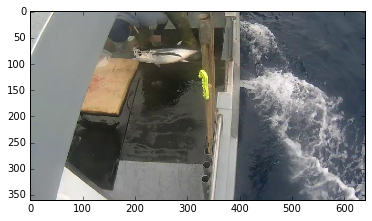

In [900]:
plt.imshow(to_plot(val[0]))

In [912]:
cm = get_cm2(inp, 0)

In [24]:
cm = get_cm2(inp, 4)

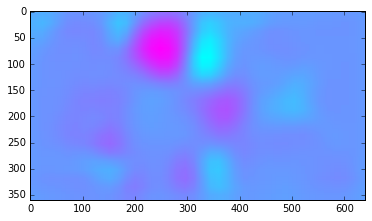

In [913]:
plt.imshow(cm, cmap="cool")

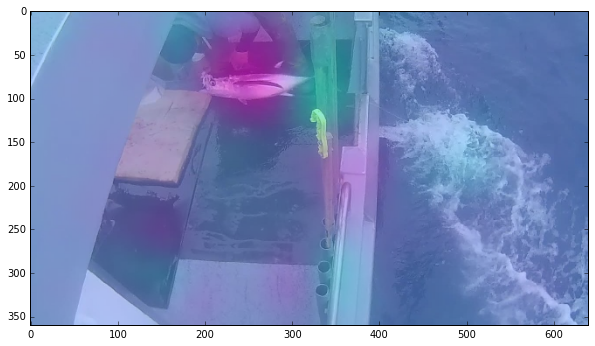

In [903]:
plt.figure(figsize=(10,10))
plot(val[0])
plt.imshow(cm, cmap="cool", alpha=0.5)

### Inception mini-net

Here's an example of how to create and use "inception blocks" - as you see, they use multiple different convolution filter sizes and concatenate the results together. We'll talk more about these next year.

In [198]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [208]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [271]:
inp = Input(vgg640.layers[-1].output_shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [272]:
lrg_model = Model([inp], outp)

In [273]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [274]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/2
3277/3277 [==============================] - 6s - loss: 1.3251 - acc: 0.5536 - val_loss: 1.4769 - val_acc: 0.5080
Epoch 2/2
3277/3277 [==============================] - 6s - loss: 0.4601 - acc: 0.8691 - val_loss: 0.9860 - val_acc: 0.7460


In [275]:
lrg_model.optimizer.lr=1e-5

In [277]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/6
3277/3277 [==============================] - 6s - loss: 0.0260 - acc: 0.9945 - val_loss: 0.2117 - val_acc: 0.9480
Epoch 2/6
3277/3277 [==============================] - 6s - loss: 0.0240 - acc: 0.9957 - val_loss: 0.3007 - val_acc: 0.9280
Epoch 3/6
3277/3277 [==============================] - 6s - loss: 0.0120 - acc: 0.9976 - val_loss: 0.2506 - val_acc: 0.9500
Epoch 4/6
3277/3277 [==============================] - 6s - loss: 0.0060 - acc: 0.9991 - val_loss: 0.2389 - val_acc: 0.9480
Epoch 5/6
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.2160 - val_acc: 0.9580
Epoch 6/6
3277/3277 [==============================] - 6s - loss: 0.0028 - acc: 0.9991 - val_loss: 0.2116 - val_acc: 0.9580


In [262]:
lrg_model.fit(conv_trn_feat, trn_labels, batch_size=batch_size, nb_epoch=10, 
             validation_data=(conv_val_feat, val_labels))

Train on 3277 samples, validate on 500 samples
Epoch 1/10
3277/3277 [==============================] - 6s - loss: 0.0029 - acc: 1.0000 - val_loss: 0.1610 - val_acc: 0.9540
Epoch 2/10
3277/3277 [==============================] - 6s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.1313 - val_acc: 0.9540
Epoch 3/10
3277/3277 [==============================] - 6s - loss: 0.0995 - acc: 0.9707 - val_loss: 0.4845 - val_acc: 0.8760
Epoch 4/10
3277/3277 [==============================] - 6s - loss: 0.1335 - acc: 0.9551 - val_loss: 0.3103 - val_acc: 0.9300
Epoch 5/10
3277/3277 [==============================] - 6s - loss: 0.0634 - acc: 0.9780 - val_loss: 0.2923 - val_acc: 0.9340
Epoch 6/10
3277/3277 [==============================] - 6s - loss: 0.0205 - acc: 0.9930 - val_loss: 0.2316 - val_acc: 0.9500
Epoch 7/10
3277/3277 [==============================] - 6s - loss: 0.0049 - acc: 0.9997 - val_loss: 0.2048 - val_acc: 0.9660
Epoch 8/10
3277/3277 [==============================] - 6s - loss: 0.0016 - ac

In [110]:
lrg_model.save_weights(path+'models/lrg_nmp.h5')

In [153]:
lrg_model.load_weights(path+'models/lrg_nmp.h5')

## Pseudo-labeling

In [210]:
preds = model.predict([conv_test_feat, test_sizes], batch_size=batch_size*2)

In [212]:
gen = image.ImageDataGenerator()

In [214]:
test_batches = gen.flow(conv_test_feat, preds, batch_size=16)

In [215]:
val_batches = gen.flow(conv_val_feat, val_labels, batch_size=4)

In [217]:
batches = gen.flow(conv_feat, trn_labels, batch_size=44)

In [292]:
mi = MixIterator([batches, test_batches, val_batches)

In [220]:
bn_model.fit_generator(mi, mi.N, nb_epoch=8, validation_data=(conv_val_feat, val_labels))

Epoch 1/8
4833/4777 [==============================] - 4s - loss: 0.2538 - acc: 0.9462 - val_loss: 0.1313 - val_acc: 0.9700
Epoch 2/8
 192/4777 [>.............................] - ETA: 2s - loss: 0.1972 - acc: 0.9635

/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:1494: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4833/4777 [==============================] - 4s - loss: 0.2231 - acc: 0.9491 - val_loss: 0.0820 - val_acc: 0.9820
Epoch 3/8
4833/4777 [==============================] - 3s - loss: 0.1860 - acc: 0.9545 - val_loss: 0.0580 - val_acc: 0.9840
Epoch 4/8
4833/4777 [==============================] - 3s - loss: 0.1559 - acc: 0.9663 - val_loss: 0.0521 - val_acc: 0.9840
Epoch 5/8
4825/4777 [==============================] - 3s - loss: 0.1366 - acc: 0.9693 - val_loss: 0.0422 - val_acc: 0.9840
Epoch 6/8
4833/4777 [==============================] - 3s - loss: 0.1303 - acc: 0.9704 - val_loss: 0.0195 - val_acc: 0.9940
Epoch 7/8
4833/4777 [==============================] - 3s - loss: 0.1283 - acc: 0.9708 - val_loss: 0.0133 - val_acc: 0.9940
Epoch 8/8
4833/4777 [==============================] - 4s - loss: 0.1199 - acc: 0.9752 - val_loss: 0.0247 - val_acc: 0.9900


## Submit

In [39]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/7, mx)

In [829]:
lrg_model.evaluate(conv_val_feat, val_labels, batch_size*2)

500/500 [==============================] - 0s     


[0.11417267167568207, 0.97199999332427978]

In [40]:
preds = lrg_model.predict(conv_test_feat, batch_size=batch_size)


In [5]:
# save_array(path+"results/preds.dat",preds)
# preds = load_array(path+"results/preds.dat")
preds = load_array(path+"results/preds_with_train_n_test_augmentation_val_acc_0.9675.dat")

nofish_prob = load_array("data/fishnofish/results/preds_640_loss_0.0244_acc_0.9913_val_loss_0.2086_val_acc_0.9778.dat")

In [6]:
preds.shape

(1000, 7)

In [25]:
# test = load_array(path+'results/large_fccn_maxpooling.dat')
# test = load_array(path+'results/test.dat')
# test.shape

In [50]:
from models import Vgg16BN
vgg = Vgg16BN(size=(270, 480), n_classes=2, lr=0.001,
              batch_size=32, dropout=0.3)

vgg.build()


In [53]:
vgg.model.load_weights('data/fishnofish/models/fish_detector_480x270/loss_0.7708_acc_0.6688_val_loss_0.4053_val_acc_0.8000.h5')

In [55]:
#1 is No-fish, 0 isfish
nofish_prob, wth = vgg.test(path+"test", 1000, aug=False)
# nofish_prob = nofish_prob[:, 1]
    

Found 1000 images belonging to 1 classes.


In [70]:
nofish_prob.shape

(1000, 2)

In [7]:
nofish_prob[:,0].mean(),nofish_prob[:,1].mean()

(0.8556807, 0.14431928)

In [8]:
nofish_prob = nofish_prob[:, 1]
# np.max(nofish_prob)

In [9]:
nofish_prob.mean(),nofish_prob.max()

(0.14431928, 1.0)

In [11]:
with_nofish_probs = np.insert(preds, 4, nofish_prob, axis=1)


In [15]:
with_nofish_probs[:,4].mean(),with_nofish_probs[:,4].max()

(0.14431928678704981, 1.0)

In [20]:
bw_df = pd.DataFrame(with_nofish_probs, columns=classes)
bw_df.insert(0, 'image', raw_test_filenames)
bw_df.ix[46:50,::]

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
46,img_02865.jpg,0.187382,0.010705,0.075211,0.002969,0.999704,0.124590,0.190027,0.409116
47,img_02209.jpg,0.080819,0.000322,0.167093,0.001064,0.003700,0.198567,0.008020,0.544116
48,img_03238.jpg,0.963387,0.000012,0.000029,0.000019,0.004939,0.036094,0.000005,0.000454
49,img_06238.jpg,0.986857,0.000538,0.001068,0.000108,0.926446,0.005291,0.005003,0.001136
50,img_06285.jpg,0.001089,0.000013,0.001219,0.000073,0.000740,0.000284,0.000108,0.997215


In [21]:
def weight_predictions(predictions):
    """Weights predictions based on probability image contains a fish as predicted by fish detector model"""
    no_fish = predictions[:, 4]
    fish = np.delete(predictions, 4, axis=1)

    weights = -1. * (no_fish - 1.)
    weights = weights.reshape(1000, 1)

    fish = weights * fish
    preds = np.insert(fish, 4, no_fish, axis=1)

    return preds


In [22]:
weighted_preds = weight_predictions(with_nofish_probs)

In [35]:
# subm = do_clip(weighted_preds,0.82)
# clip = 0.3
# subm = np.clip(weighted_preds, clip, 1-clip)
f = 0.75 #was 0.82
subm = np.clip(weighted_preds, (1-f)/7, f)

In [36]:
subm[:,4].mean(),subm[:,4].max()

(0.14125444643465537, 0.75)

In [37]:
subm_name = path+'submit/train_test_augmentation_val_acc9675_clip75.gz'

In [38]:
# classes = sorted(batches.class_indices, key=batches.class_indices.get)
classes = ['ALB', 'BET', 'DOL', 'LAG','NoF', 'OTHER', 'SHARK', 'YFT']

In [39]:

submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_06237.jpg,0.750000,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
1,img_06893.jpg,0.551769,0.035714,0.035714,0.035714,0.035714,0.106299,0.035714,0.309322
2,img_02082.jpg,0.648756,0.035714,0.035714,0.035714,0.351145,0.035714,0.035714,0.035714
3,img_06261.jpg,0.750000,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714
4,img_03628.jpg,0.750000,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714


In [40]:
submission.ix[46:50,::]

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
46,img_02865.jpg,0.035714,0.035714,0.035714,0.035714,0.750000,0.035714,0.035714,0.035714
47,img_02209.jpg,0.080520,0.035714,0.166475,0.035714,0.035714,0.197832,0.035714,0.542103
48,img_03238.jpg,0.750000,0.035714,0.035714,0.035714,0.035714,0.035916,0.035714,0.035714
49,img_06238.jpg,0.072587,0.035714,0.035714,0.035714,0.750000,0.035714,0.035714,0.035714
50,img_06285.jpg,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.750000


In [41]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [42]:
FileLink(subm_name)

/home/ubuntu/fish/data/nof_excl/submit/train_test_augmentation_val_acc9675_clip75.gz

#### check predictions 

In [21]:
nofish_prob.shape

(1000, 2)

In [24]:
tp = pd.DataFrame(nofish_prob, columns=["Fish","NoF"])
tp.insert(0, 'image', raw_test_filenames)
tp.head()




,image,Fish,NoF
0,img_06237.jpg,0.999582,0.000418
1,img_06893.jpg,0.994870,0.005130
2,img_02082.jpg,0.648855,0.351145
3,img_06261.jpg,0.994695,0.005305
4,img_03628.jpg,0.999579,0.000421


In [54]:
sp = pd.DataFrame(preds, columns=['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT'])
sp.insert(0, 'image', raw_test_filenames)
sp.head()


,image,ALB,BET,DOL,LAG,OTHER,SHARK,YFT
0,img_06237.jpg,0.999781,0.000188,0.000022,0.000002,7.947198e-07,4.677605e-07,0.000006
1,img_06893.jpg,0.725381,0.004820,0.003509,0.001260,1.520285e-01,1.024696e-01,0.010532
2,img_02082.jpg,0.998157,0.000003,0.000002,0.000002,4.607791e-06,1.790431e-03,0.000041
3,img_06261.jpg,0.998058,0.000109,0.000014,0.000016,8.528832e-04,1.496271e-04,0.000801
4,img_03628.jpg,0.999849,0.000056,0.000006,0.000002,7.053000e-05,5.458475e-06,0.000012


image    img_06285.jpg
Fish           0.99926
NoF        0.000739648
Name: 50, dtype: object
ALB       2.3093e-07
BET      7.08835e-08
DOL      1.87159e-07
LAG      2.03162e-08
OTHER    7.74162e-08
SHARK    9.01833e-08
YFT         0.999999
Name: 50, dtype: object



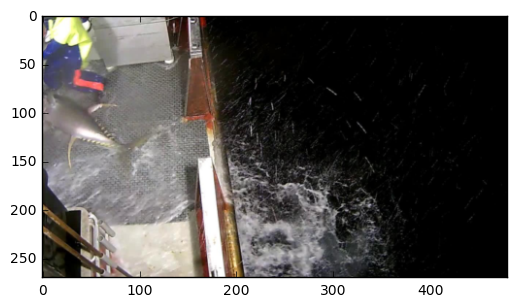

In [92]:
i = 50
print (tp.ix[i,:])
print (sp.ix[i,1:])
print ()
im = imresize(load_img("data/nof_excl/test/test_stg1/"+tp.image[i]), size=(270, 480))
plt.imshow(im)

In [74]:
weights = -1. * (tp.ix[i,2] - 1.)
# weights = weights.reshape(1000, 1)
print (weights)
fish = weights * sp.ix[i,1:]

fish

0.999258517171


ALB      8.40471e-07
BET       0.00255019
DOL       0.00157739
LAG      3.10552e-05
OTHER    5.25542e-05
SHARK    4.59232e-05
YFT         0.995001
Name: 40, dtype: object

In [69]:
np.max(((1-0.82)/7),0.0735464)

0.025714285714285721